In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_ids = pd.read_excel('./raw/Supplementary_Table_1.xlsx', sheet_name='12. Clinical and RNAseq IDs')
df_ids['is_in_FreeMan'] = df_ids.in_primary_154 | df_ids.in_secondary_180
df_ids = df_ids[['rna_id', 'cohort', 'participant', 'clinical_rna_id','is_in_FreeMan']]
df_ids.to_csv('./raw/alldatasets_mgh_id.csv')

In [3]:
sid2rnaid_map =  df_ids.set_index('clinical_rna_id').rna_id
sid2rnaid_map

clinical_rna_id
Pt1               Pt1-baseline
Pt10             Pt10-baseline
Pt12             Pt12-baseline
Pt13             Pt13-baseline
Pt14             Pt14-baseline
                     ...      
Patient94_T_P    Patient94_T_P
Patient96_T_P    Patient96_T_P
Patient98_T_P    Patient98_T_P
Patient99_T_P    Patient99_T_P
Patient9_T_M      Patient9_T_M
Name: rna_id, Length: 457, dtype: object

In [4]:
df_samples = pd.read_excel('./raw/Samples_MGH.xlsx')
df_samples['rna_id'] = df_samples.Sample_id.map(sid2rnaid_map)
df_samples['is_in_FreeMan'] = df_samples.index.map(df_ids.is_in_FreeMan)
df_samples = df_samples.set_index('Sample_id')
df_samples.index.name = 'samples'
df_samples.columns = df_samples.columns.map(lambda x:x.lower())
df_samples = df_samples.rename(columns={'overall_survival':'survival', 'response ':'response','alive (y=1, no=0)':'status'})
df_samples['flag'] = df_samples.response.map({'R':1, 'NR':0})
df_samples.head(3)

,patient,age,gender,primary_tumor,survival,status,timing,response,therapy,prior_ctla4,source_of_sample,rna_id,is_in_freeman,flag
samples,,,,,,,,,,,,,,
102AR,102T,44,F,Uveal,786,1,Pre,R,CTLA4,False,Frozen,102T-Tumor-SM-BZ9XL,True,1
107AR,107T,63,F,Uveal,998,0,Pre,NR,CTLA4,False,Frozen,107T-Tumor-SM-BZ9WD,True,0
115AR,115T,66,M,Skin,1092,1,Pre,NR,CTLA4,False,Frozen,115T-Tumor-SM-BZ9WG,True,0


### calculate TMB

<Axes: >

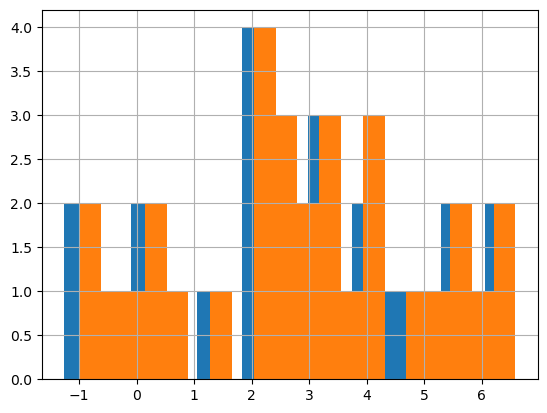

In [5]:
captureSize = 35.8 #for tmb claculation
VC_NONSYNONYMOUS_LIST = ['Frame_Shift_Del',
                         'Frame_Shift_Ins',
                         'In_Frame_Del',
                         'In_Frame_Ins',
                         'Missense_Mutation',
                         'Nonsense_Mutation',
                         'Splice_Site',
                         'Nonstop_Mutation',
                         'Splice_Region']

truncate_mut_LIST = ['Nonsense_Mutation', 'Frame_Shift_Ins','Frame_Shift_Del','Splice_Site']
nontruncate_mut_LIST = ['Missense_Mutation','In_Frame_Del', 'In_Frame_Ins','Nonstop_Mutation']

mut = pd.read_excel('./raw/Supplementary_Table_2.xlsx', sheet_name='1. WES somatic mutation calls')
mut_series = mut['Variant_Classification']

mut['nansynonymous_mut_flag'] = mut_series.isin(VC_NONSYNONYMOUS_LIST)
mut['truncate_mut_flag'] = mut_series.isin(truncate_mut_LIST)
mut['nontruncate_mut_flag'] = mut_series.isin(nontruncate_mut_LIST)

I_calculated_TMB1 = mut.groupby('Tumor_Sample_Barcode').nansynonymous_mut_flag.sum()
I_calculated_TMB2 = mut.groupby('Tumor_Sample_Barcode').apply(lambda x:x.truncate_mut_flag.sum()*2+x.nontruncate_mut_flag.sum())

#for tmb claculation
tmb1 = np.log2(I_calculated_TMB1/captureSize)
tmb2 = np.log2(I_calculated_TMB2/captureSize)

tmb = tmb1.to_frame('tmb.dan').join(tmb2.to_frame(name = 'tmb.wang'))
tmb = tmb[tmb.index.map(lambda x:x.split('-')[0]).isin(df_samples.patient)]
tmb.index = tmb.index.map(lambda x:x.split('-')[0])

df_samples['tmb.dan'] = df_samples.patient.map(tmb['tmb.dan'])
df_samples['tmb.wang'] = df_samples.patient.map(tmb['tmb.wang'])


df_samples['tmb.dan'].hist(bins=20)
df_samples['tmb.wang'].hist(bins=20)

## mRNA

In [6]:
dfm = pd.read_excel('./raw/Supplementary_Table_4.xlsx',sheet_name = '8. Pre_batch_correction', index_col=0)
dfm = dfm[df_samples.rna_id]
df_mRNA_tpm = 2**dfm-1
gene_ensid_name_map = pd.read_pickle('/n/data1/hms/dbmi/zitnik/lab/users/was966/TCGA/GDC_v37/gene_ensid_name.map')
df_mRNA_tpm.index = df_mRNA_tpm.index.map(gene_ensid_name_map)
df_mRNA_tpm = df_mRNA_tpm[~df_mRNA_tpm.index.isna()]
df_mRNA_tpm.columns = df_mRNA_tpm.columns.map(df_samples.reset_index().set_index('rna_id').samples)

In [7]:
dfm.shape

(19820, 40)

In [20]:
df_samples.to_csv('./processed/samples.csv')
df_mRNA_tpm.round(5).to_csv('./processed/abundance.csv')

In [21]:
df_mRNA_tpm.shape, df_samples.shape

((19070, 40), (40, 16))

In [10]:
gene_id_type_map = pd.read_pickle('/n/data1/hms/dbmi/zitnik/lab/users/was966/TCGA/GDC_v37/gene_id_type.map')
gene_id_type_map.index = gene_id_type_map.index.map(lambda x:x.split('.')[0])
gene_id_type_map.index = gene_id_type_map.index.map(gene_ensid_name_map)
gene_name_type_map = gene_id_type_map.dropna()